<a href="https://colab.research.google.com/github/prawizard/CE888_Repo/blob/main/Lab_8/Task_Lab_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "prawizard" # username from the json file
os.environ['KAGGLE_KEY'] = "7a403fa6105c4d269dea7753dcfe811a" # key from the json file
!kaggle competitions download -c dogs-vs-cats # api copied from kaggle (https://www.kaggle.com/c/dogs-vs-cats/data)

 97% 262M/271M [00:02<00:00, 103MB/s] 
100% 271M/271M [00:02<00:00, 98.7MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 77.7MB/s]
 99% 539M/543M [00:04<00:00, 157MB/s]
100% 543M/543M [00:04<00:00, 139MB/s]


In [ ]:
# Unzip training data
from zipfile import ZipFile
file_name = "/content/data.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [ ]:
# Get all the paths
data_dir_list = os.listdir('/content/train')
#print(data_dir_list)
path, dirs, files = next(os.walk("/content/train"))
file_count = len(files)
print(file_count)

25000


In [12]:
# Make new base directory
original_dataset_dir = '/content/data'
base_dir = '/content/data_exp'
os.mkdir(base_dir)

cats_base_dir='/content/data/cats'
dogs_base_dir='/content/data/dogs'
Humans_base_dir='/content/data/Humans'
horses_base_dir='/content/data/horses'

In [13]:
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [15]:
import shutil
fnames = ['cat.{}.jpg'.format(i) for i in range(1, 100)]
for fname in fnames:
    src = os.path.join(cats_base_dir, fname)
    dst = os.path.join(train_dir, fname)
    #print(src,dst)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(101, 150)]
for fname in fnames:
    src = os.path.join(cats_base_dir, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(151, 202)]
for fname in fnames:
    src = os.path.join(cats_base_dir, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1, 100)]
for fname in fnames:
    src = os.path.join(dogs_base_dir, fname)
    dst = os.path.join(train_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(101, 150)]
for fname in fnames:
    src = os.path.join(dogs_base_dir, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(151, 202)]
for fname in fnames:
    src = os.path.join(dogs_base_dir, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['horse-{}.jpg'.format(i) for i in range(1, 100)]
for fname in fnames:
    src = os.path.join(horses_base_dir, fname)
    dst = os.path.join(train_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['horse-{}.jpg'.format(i) for i in range(101, 150)]
for fname in fnames:
    src = os.path.join(horses_base_dir, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['horse-{}.jpg'.format(i) for i in range(151, 202)]
for fname in fnames:
    src = os.path.join(horses_base_dir, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['rider-{}.jpg'.format(i) for i in range(1, 100)]
for fname in fnames:
    src = os.path.join(Humans_base_dir, fname)
    dst = os.path.join(train_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['rider-{}.jpg'.format(i) for i in range(101, 150)]
for fname in fnames:
    src = os.path.join(Humans_base_dir, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['rider-{}.jpg'.format(i) for i in range(151, 202)]
for fname in fnames:
    src = os.path.join(Humans_base_dir, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

In [16]:
import cv2
import numpy as np
from random import shuffle

IMG_SIZE = 224
LR = 1e-4

In [29]:
def label_img(img):
    word_label = img.split('.')[0]
    if word_label == 'dog': return 1
    elif word_label == 'cat': return 0
    word_label = img.split('-')[0]
    if word_label == 'horse': return 2
    elif word_label == 'rider': return 3

In [30]:
def createDataSplitSet(datapath):
    X=[]
    y=[]

    for img in os.listdir(datapath):
        label = label_img(img)
        # print(label)
        path = os.path.join(datapath, img)
        image = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        X.append(np.array(image))
        y.append(label)

    return np.array(X), np.array(y)

In [31]:
train_X, train_y = createDataSplitSet(train_dir)
val_X, val_y = createDataSplitSet(validation_dir)
test_X, test_y = createDataSplitSet(test_dir)

In [24]:
a = np.array([1, 0, 3,1])
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1
b

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [35]:
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer

# onehotencoder = OneHotEncoder()
# columnTransformer = ColumnTransformer([('encoder',
#                                         OneHotEncoder(),
#                                         [0])],
#                                       remainder='passthrough')
# temp_x=np.array(columnTransformer.fit_transform(train_y))

temp = np.array(train_y)
train_y_ohe = np.zeros((temp.size, temp.max()+1))
train_y_ohe[np.arange(temp.size),temp] = 1


temp = np.array(val_y)
val_y_ohe = np.zeros((temp.size, temp.max()+1))
val_y_ohe[np.arange(temp.size),temp] = 1

temp = np.array(test_y)
test_y_ohe = np.zeros((temp.size, temp.max()+1))
test_y_ohe[np.arange(temp.size),temp] = 1



In [36]:
train_y_ohe[:5]

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]])

In [37]:
train_y[:5]

array([1, 3, 3, 0, 2])

In [39]:
## VGG 16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model

img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [40]:
model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax")
model.summary()

553467904/553467096 [==============================] - 15s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [45]:
last_layer = model.get_layer('fc2').output
out = Dense(4, activation='softmax', name='output')(last_layer)  ## 2 classes
model = Model(img_input, out)

for layer in model.layers[:-1]:
	layer.trainable = False

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [46]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [47]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='vgg16_model.h5', save_best_only=True),
]

In [48]:
history = model.fit(train_X, train_y_ohe,
                               batch_size=10,
                               epochs=10, 
                               validation_data=(val_X, val_y_ohe),
                               callbacks=my_callbacks)

Epoch 1/10
40/40 [==============================] - 44s 272ms/step - loss: 1.7018 - acc: 0.2818 - val_loss: 0.6560 - val_acc: 0.8316
Epoch 2/10
40/40 [==============================] - 8s 198ms/step - loss: 0.6974 - acc: 0.7673 - val_loss: 0.4579 - val_acc: 0.8724
Epoch 3/10
40/40 [==============================] - 8s 197ms/step - loss: 0.5058 - acc: 0.8427 - val_loss: 0.4361 - val_acc: 0.8571
Epoch 4/10
40/40 [==============================] - 8s 197ms/step - loss: 0.5030 - acc: 0.8103 - val_loss: 0.3379 - val_acc: 0.9235
Epoch 5/10
40/40 [==============================] - 8s 197ms/step - loss: 0.5097 - acc: 0.7881 - val_loss: 0.3191 - val_acc: 0.9031
Epoch 6/10
40/40 [==============================] - 8s 197ms/step - loss: 0.3347 - acc: 0.8944 - val_loss: 0.3091 - val_acc: 0.8929
Epoch 7/10
40/40 [==============================] - 8s 197ms/step - loss: 0.3617 - acc: 0.8558 - val_loss: 0.3167 - val_acc: 0.8878
Epoch 8/10
40/40 [==============================] - 8s 197ms/step - loss: 0

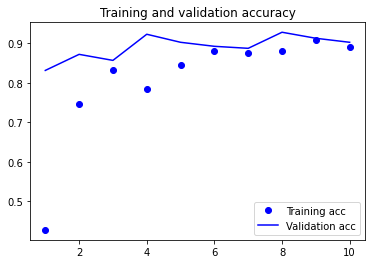

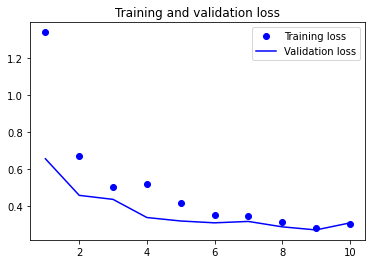

In [49]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [65]:
from sklearn.metrics import accuracy_score

## Test Accuracy
predictions = model.predict(test_X)
y_pred=[]
for i in range(len(predictions)):
  res=np.argmax(predictions[i])
  y_pred.append(res)
ypred=np.array(y_pred)

test_acc = accuracy_score(test_y, ypred)

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(test_y, ypred, average='macro')


print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)


Train Accuracy:	 0.8914141654968262
Val Accuracy:	 0.9030612111091614
Test Accuracy:	 0.8627450980392157
Precision:	 0.8794796073917371
Recall:		 0.8627450980392156
F1 Score:	 0.8658652604390874
